WORKSHOP 4

Angel Molina

Daniel Marin

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter

# Load the dataset
df = pd.read_csv('./llm/train.tsv', sep='\t')


In [29]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase
    tokens = text.split()  # Simple tokenization
    # Add more preprocessing steps like removing stopwords, lemmatization if needed
    return ' '.join(tokens)

<ipython-input-30-a22f7f17a25a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].map({0: 0, 2: 1, 4: 2})
<ipython-input-30-a22f7f17a25a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_labels'] = df['Sentiment'].map(class_labels)


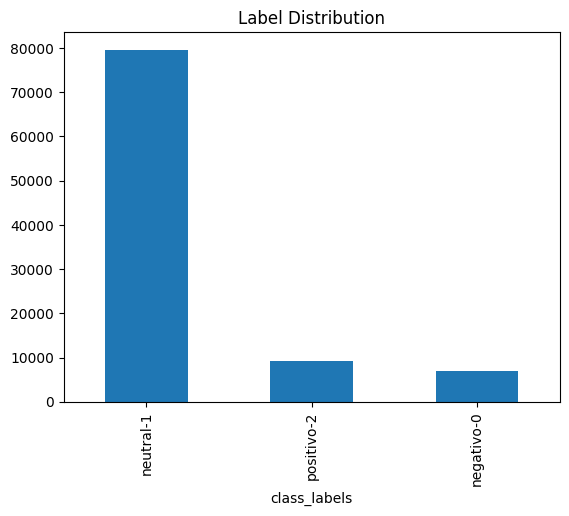

(95860, 5)


,PhraseId,SentenceId,Phrase,Sentiment,class_labels
1,2,1,A series of escapades demonstrating the adage ...,1,neutral-1
2,3,1,A series,1,neutral-1
3,4,1,A,1,neutral-1
4,5,1,series,1,neutral-1
5,6,1,of escapades demonstrating the adage that what...,1,neutral-1


In [30]:
df = df[df['Sentiment'].isin([0, 2, 4])]

# Recategorizar a 0, 1, 2
df['Sentiment'] = df['Sentiment'].map({0: 0, 2: 1, 4: 2})

class_labels = {
    0: 'negativo-0',
    1: 'neutral-1',
    2: 'positivo-2'
}

df['class_labels'] = df['Sentiment'].map(class_labels)

label_counts = df['class_labels'].value_counts()
label_counts.plot(kind='bar', title='Label Distribution')
plt.show()

print(df.shape)
df.head()

In [31]:
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer

# Initialize the tokenizer
tokenizer = TreebankWordTokenizer()

# Tokenize each phrase
df['tokenized_phrase'] = df['Phrase'].apply(lambda x: tokenizer.tokenize(x))

# Preview the result
print(df[['Phrase', 'tokenized_phrase']].head())


                                              Phrase  \
1  A series of escapades demonstrating the adage ...   
2                                           A series   
3                                                  A   
4                                             series   
5  of escapades demonstrating the adage that what...   

                                    tokenized_phrase  
1  [A, series, of, escapades, demonstrating, the,...  
2                                        [A, series]  
3                                                [A]  
4                                           [series]  
5  [of, escapades, demonstrating, the, adage, tha...  


#No data pre processing

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Create Bag of Words model
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['Phrase'])

display(X_bow)
print(vectorizer.get_feature_names_out())

<95860x15168 sparse matrix of type '<class 'numpy.int64'>'
	with 519576 stored elements in Compressed Sparse Row format>

['000' '10' '100' ... 'zucker' 'zwick' 'zzzzzzzzz']


In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Stratified split with random_state=13 and test_size=0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

# Reset index to ensure alignment
df = df.reset_index(drop=True)  # Reset index and drop the old index

for train_index, test_index in sss.split(X_bow, df['Sentiment']):
    X_train, X_test = X_bow[train_index], X_bow[test_index]
    y_train, y_test = df['Sentiment'][train_index], df['Sentiment'][test_index]

In [34]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_bow is a sparse matrix (e.g., from CountVectorizer)
# Convert sparse matrices to dense arrays
X_train_dense = X_train.toarray()  # Convert the csr_matrix to a dense NumPy array
X_test_dense = X_test.toarray()

# Convert the data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_dense, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_dense, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [35]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

classes = ['negative', 'neutral', 'positive']

def train_model(model, train_loader, test_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Lists to store metrics for graphing
    train_losses = []
    test_losses = []
    train_f1_scores = []
    test_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []

        for batch_X, batch_y in train_loader:
           # batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to device
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_preds.append(predicted.cpu().numpy())
            all_train_labels.append(batch_y.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        y_train_pred = np.concatenate(all_train_preds)
        y_train_true = np.concatenate(all_train_labels)
        train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')

        # Evaluation
        model.eval()
        test_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                #batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to device
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu().numpy())
                all_labels.append(batch_y.cpu().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        y_test_pred = np.concatenate(all_preds)
        y_test_true = np.concatenate(all_labels)
        test_f1 = f1_score(y_test_true, y_test_pred, average='weighted')
        test_f1_scores.append(test_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}')

        print("____________________________")

    # Plot the results
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, label='Training F1 Score')
    plt.plot(epochs, test_f1_scores, label='Test F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final Evaluation
    accuracy = accuracy_score(y_test_true, y_test_pred)
    report = classification_report(y_test_true, y_test_pred, target_names=classes)

    print(f'Final Test Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, y_test_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [36]:
# Reshape input data
X_train_reshaped = X_train_dense.reshape(X_train_dense.shape[0], 1, X_train_dense.shape[1])
X_test_reshaped = X_test_dense.reshape(X_test_dense.shape[0], 1, X_test_dense.shape[1])

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## RNN

Epoch 1/10, Train Loss: 0.3428, Train F1: 0.8769
Epoch 1/10, Test Loss: 0.2903, Test F1: 0.9000
____________________________
Epoch 2/10, Train Loss: 0.2083, Train F1: 0.9241
Epoch 2/10, Test Loss: 0.3102, Test F1: 0.9035
____________________________
Epoch 3/10, Train Loss: 0.1566, Train F1: 0.9423
Epoch 3/10, Test Loss: 0.3083, Test F1: 0.9057
____________________________
Epoch 4/10, Train Loss: 0.1251, Train F1: 0.9540
Epoch 4/10, Test Loss: 0.3583, Test F1: 0.9096
____________________________
Epoch 5/10, Train Loss: 0.1008, Train F1: 0.9640
Epoch 5/10, Test Loss: 0.3737, Test F1: 0.9092
____________________________
Epoch 6/10, Train Loss: 0.0842, Train F1: 0.9701
Epoch 6/10, Test Loss: 0.4102, Test F1: 0.9113
____________________________
Epoch 7/10, Train Loss: 0.0709, Train F1: 0.9748
Epoch 7/10, Test Loss: 0.4793, Test F1: 0.9042
____________________________
Epoch 8/10, Train Loss: 0.0627, Train F1: 0.9781
Epoch 8/10, Test Loss: 0.5143, Test F1: 0.9081
____________________________


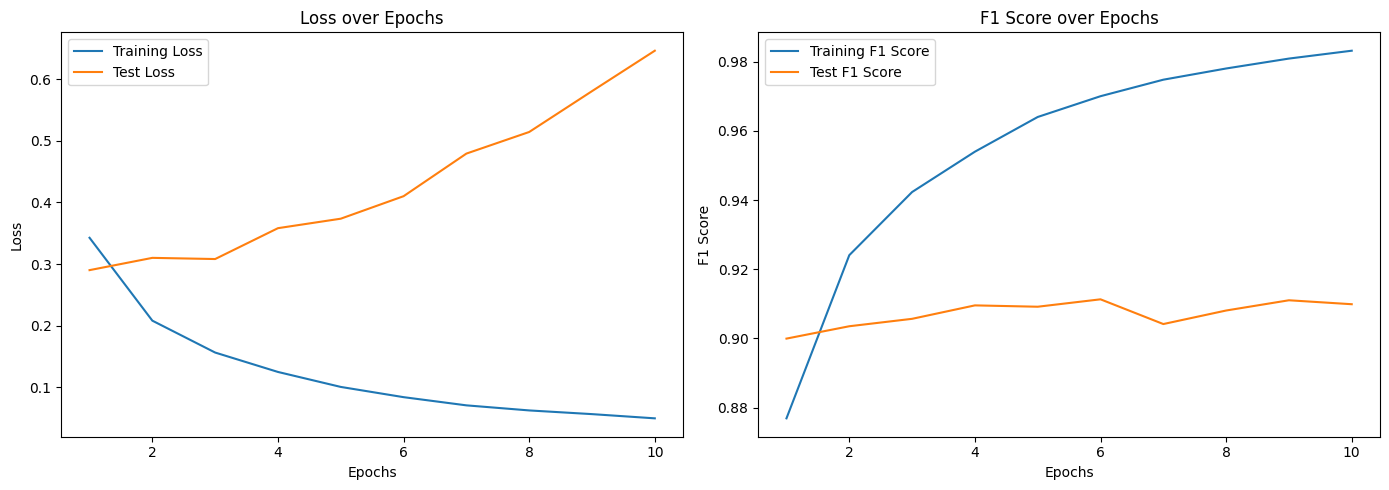

Final Test Accuracy: 0.9123

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67      1415
     neutral       0.94      0.96      0.95     15916
    positive       0.84      0.70      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



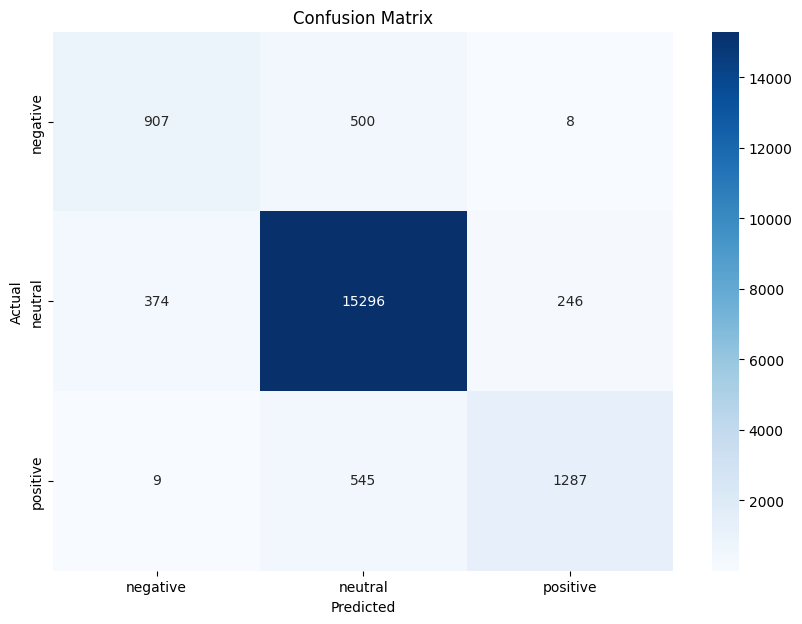

In [37]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize RNN model
rnn_model = RNNModel(input_size=X_train_dense.shape[1], hidden_size=128, output_size=len(set(y_train)))

# Training and evaluation process
# (this will be the same for LSTM and GRU)
train_model(rnn_model, train_loader, test_loader, num_epochs=10)


##LSTM

Epoch 1/10, Train Loss: 0.3180, Train F1: 0.8835
Epoch 1/10, Test Loss: 0.2588, Test F1: 0.9073
____________________________
Epoch 2/10, Train Loss: 0.1677, Train F1: 0.9375
Epoch 2/10, Test Loss: 0.2658, Test F1: 0.9135
____________________________
Epoch 3/10, Train Loss: 0.1100, Train F1: 0.9585
Epoch 3/10, Test Loss: 0.2945, Test F1: 0.9165
____________________________
Epoch 4/10, Train Loss: 0.0749, Train F1: 0.9716
Epoch 4/10, Test Loss: 0.3439, Test F1: 0.9137
____________________________
Epoch 5/10, Train Loss: 0.0563, Train F1: 0.9784
Epoch 5/10, Test Loss: 0.3782, Test F1: 0.9133
____________________________
Epoch 6/10, Train Loss: 0.0437, Train F1: 0.9832
Epoch 6/10, Test Loss: 0.4263, Test F1: 0.9160
____________________________
Epoch 7/10, Train Loss: 0.0361, Train F1: 0.9853
Epoch 7/10, Test Loss: 0.4877, Test F1: 0.9145
____________________________
Epoch 8/10, Train Loss: 0.0305, Train F1: 0.9873
Epoch 8/10, Test Loss: 0.5036, Test F1: 0.9134
____________________________


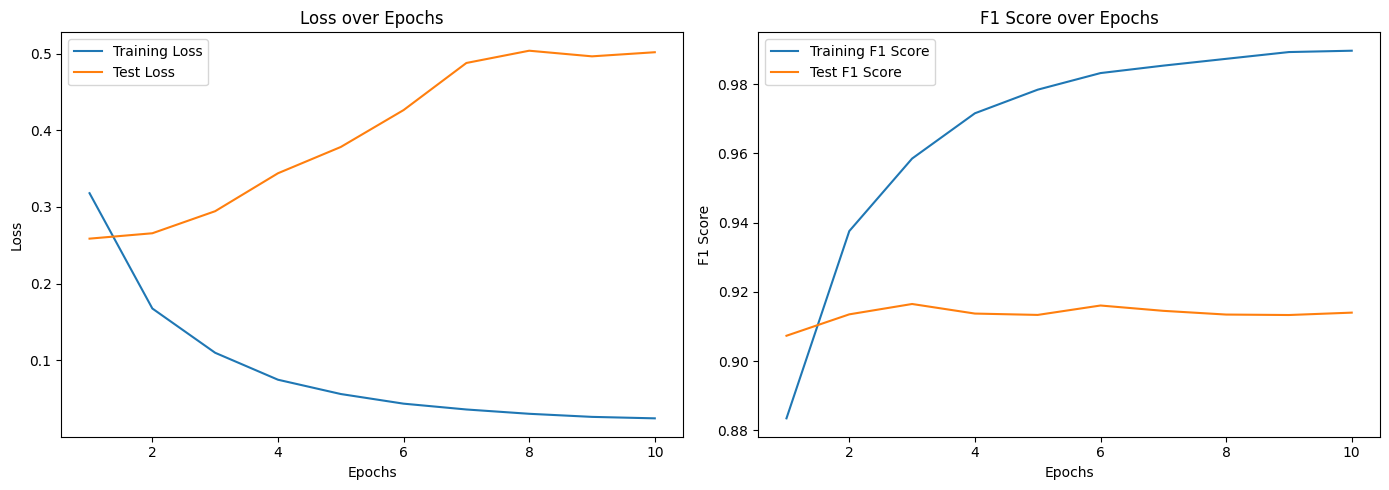

Final Test Accuracy: 0.9154

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.66      0.68      1415
     neutral       0.94      0.96      0.95     15916
    positive       0.82      0.74      0.78      1841

    accuracy                           0.92     19172
   macro avg       0.82      0.79      0.80     19172
weighted avg       0.91      0.92      0.91     19172



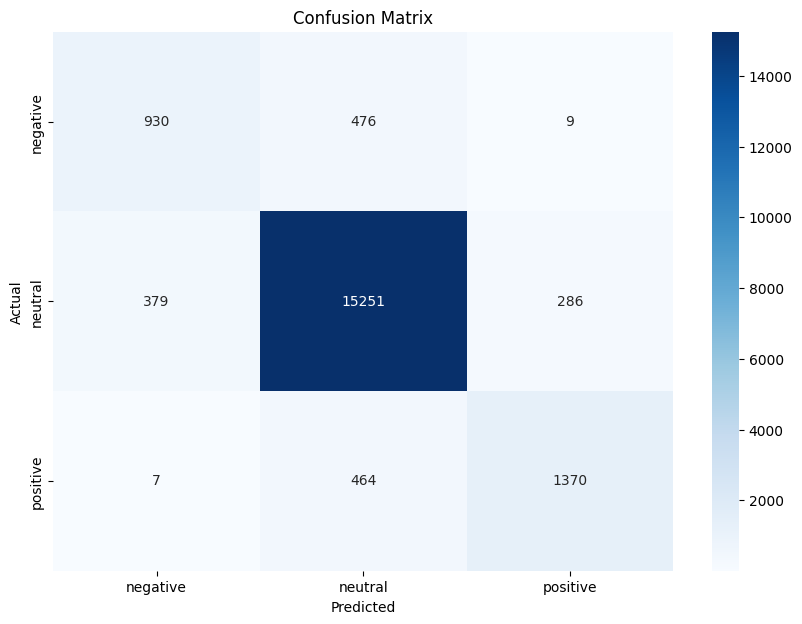

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize LSTM model
lstm_model = LSTMModel(input_size=X_train_dense.shape[1], hidden_size=128, output_size=len(set(y_train)))

# Training and evaluation process
train_model(lstm_model, train_loader, test_loader, num_epochs=10)


##GRU

Epoch 1/10, Train Loss: 0.3204, Train F1: 0.8833
Epoch 1/10, Test Loss: 0.2628, Test F1: 0.9098
____________________________
Epoch 2/10, Train Loss: 0.1725, Train F1: 0.9367
Epoch 2/10, Test Loss: 0.2624, Test F1: 0.9162
____________________________
Epoch 3/10, Train Loss: 0.1149, Train F1: 0.9557
Epoch 3/10, Test Loss: 0.3011, Test F1: 0.9147
____________________________
Epoch 4/10, Train Loss: 0.0808, Train F1: 0.9692
Epoch 4/10, Test Loss: 0.3390, Test F1: 0.9148
____________________________
Epoch 5/10, Train Loss: 0.0592, Train F1: 0.9769
Epoch 5/10, Test Loss: 0.3657, Test F1: 0.9129
____________________________
Epoch 6/10, Train Loss: 0.0469, Train F1: 0.9813
Epoch 6/10, Test Loss: 0.4338, Test F1: 0.9133
____________________________
Epoch 7/10, Train Loss: 0.0389, Train F1: 0.9849
Epoch 7/10, Test Loss: 0.4999, Test F1: 0.9142
____________________________
Epoch 8/10, Train Loss: 0.0327, Train F1: 0.9871
Epoch 8/10, Test Loss: 0.4930, Test F1: 0.9129
____________________________


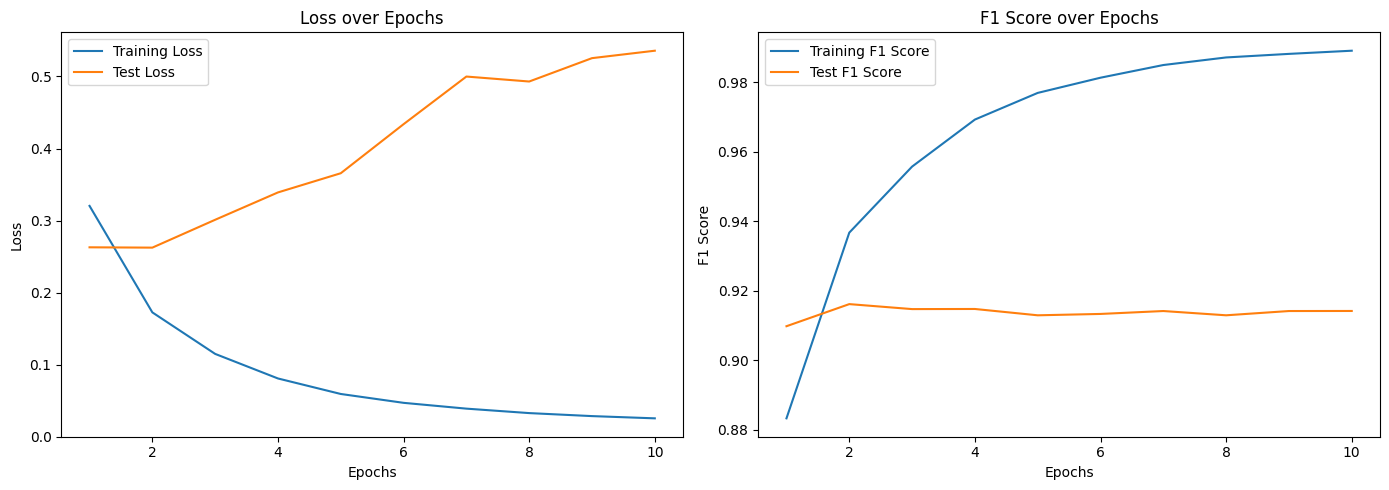

Final Test Accuracy: 0.9156

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.65      0.68      1415
     neutral       0.94      0.96      0.95     15916
    positive       0.82      0.76      0.79      1841

    accuracy                           0.92     19172
   macro avg       0.82      0.79      0.80     19172
weighted avg       0.91      0.92      0.91     19172



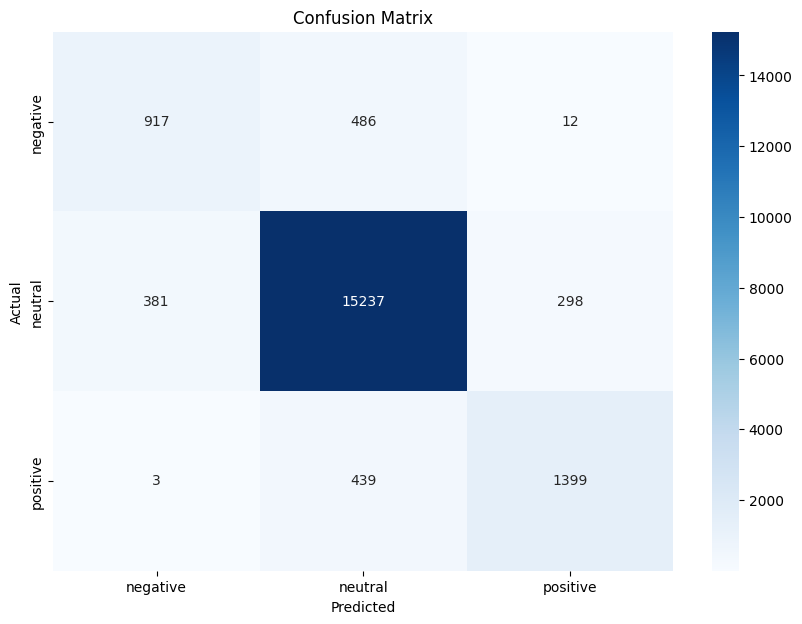

In [39]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize GRU model
gru_model = GRUModel(input_size=X_train_dense.shape[1], hidden_size=128, output_size=len(set(y_train)))

# Training and evaluation process
train_model(gru_model, train_loader, test_loader, num_epochs=10)


#Results using pre processing

In [40]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function for preprocessing text
def preprocess_text(text):
    # Case folding
    text = text.lower()
    # Tokenization
    words = text.split()
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    words = [stemmer.stem(word) for word in words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the 'Phrase' column
df['cleaned_phrase'] = df['Phrase'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
vectorizer = CountVectorizer(binary=False)  # Use frequencies instead of binary vectors
X = vectorizer.fit_transform(df['cleaned_phrase'])  # Bag of Words feature matrix


In [42]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Stratified split with random_state=13 and test_size=0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

for train_index, test_index in sss.split(X, df['Sentiment']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = df['Sentiment'][train_index], df['Sentiment'][test_index]

In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_bow is a sparse matrix (e.g., from CountVectorizer)
# Convert sparse matrices to dense arrays
X_train_dense = X_train.toarray()  # Convert the csr_matrix to a dense NumPy array
X_test_dense = X_test.toarray()

# Convert the data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_dense, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_dense, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [44]:
# Reshape input data
X_train_reshaped = X_train_dense.reshape(X_train_dense.shape[0], 1, X_train_dense.shape[1])
X_test_reshaped = X_test_dense.reshape(X_test_dense.shape[0], 1, X_test_dense.shape[1])

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


##RNN

Epoch 1/10, Train Loss: 0.3588, Train F1: 0.8698
Epoch 1/10, Test Loss: 0.3109, Test F1: 0.8889
____________________________
Epoch 2/10, Train Loss: 0.2408, Train F1: 0.9104
Epoch 2/10, Test Loss: 0.2957, Test F1: 0.8983
____________________________
Epoch 3/10, Train Loss: 0.1994, Train F1: 0.9261
Epoch 3/10, Test Loss: 0.3112, Test F1: 0.8997
____________________________
Epoch 4/10, Train Loss: 0.1663, Train F1: 0.9388
Epoch 4/10, Test Loss: 0.3439, Test F1: 0.8982
____________________________
Epoch 5/10, Train Loss: 0.1420, Train F1: 0.9479
Epoch 5/10, Test Loss: 0.3437, Test F1: 0.9055
____________________________
Epoch 6/10, Train Loss: 0.1242, Train F1: 0.9543
Epoch 6/10, Test Loss: 0.3713, Test F1: 0.8997
____________________________
Epoch 7/10, Train Loss: 0.1111, Train F1: 0.9591
Epoch 7/10, Test Loss: 0.4050, Test F1: 0.9040
____________________________
Epoch 8/10, Train Loss: 0.0981, Train F1: 0.9645
Epoch 8/10, Test Loss: 0.4256, Test F1: 0.9083
____________________________


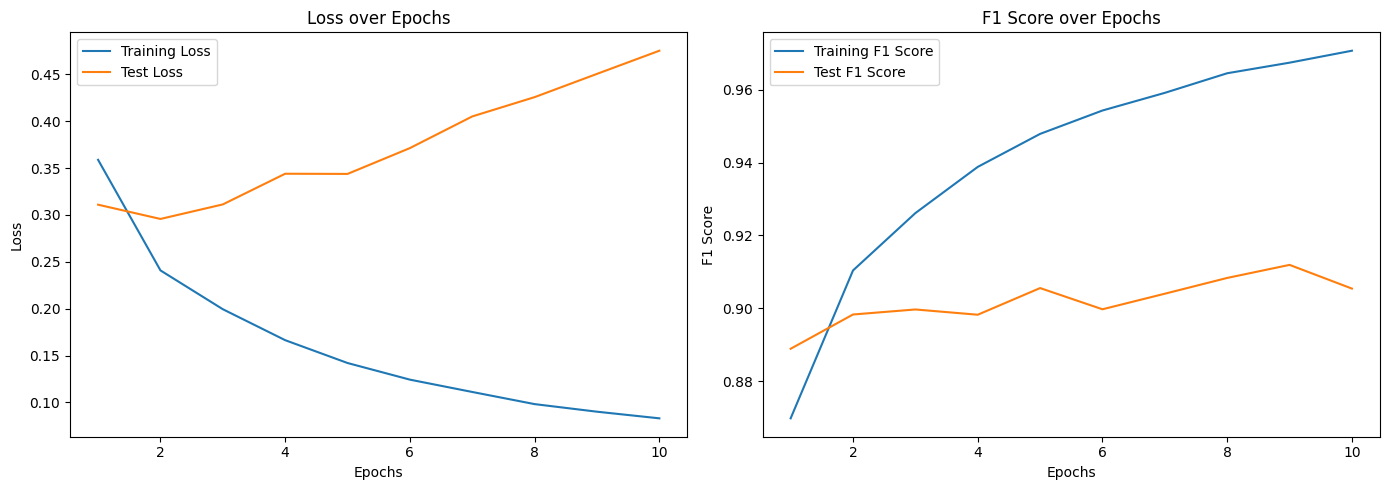

Final Test Accuracy: 0.9067

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.62      0.65      1415
     neutral       0.94      0.95      0.94     15916
    positive       0.77      0.75      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.77      0.79     19172
weighted avg       0.90      0.91      0.91     19172



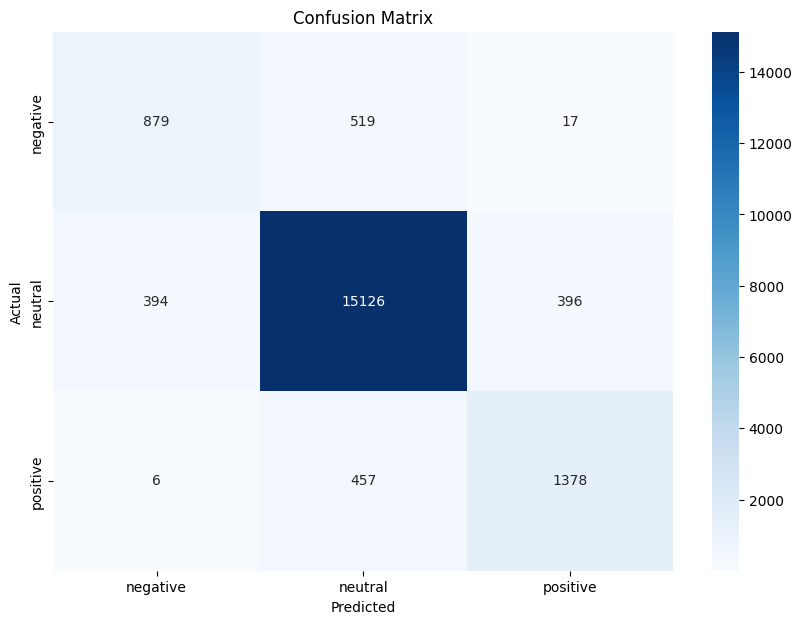

In [45]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize RNN model
rnn_model = RNNModel(input_size=X_train_dense.shape[1], hidden_size=128, output_size=len(set(y_train)))

# Training and evaluation process
# (this will be the same for LSTM and GRU)
train_model(rnn_model, train_loader, test_loader, num_epochs=10)


##LSTM

Epoch 1/10, Train Loss: 0.3352, Train F1: 0.8767
Epoch 1/10, Test Loss: 0.2743, Test F1: 0.8976
____________________________
Epoch 2/10, Train Loss: 0.1995, Train F1: 0.9255
Epoch 2/10, Test Loss: 0.2720, Test F1: 0.9116
____________________________
Epoch 3/10, Train Loss: 0.1457, Train F1: 0.9454
Epoch 3/10, Test Loss: 0.2884, Test F1: 0.9134
____________________________
Epoch 4/10, Train Loss: 0.1106, Train F1: 0.9563
Epoch 4/10, Test Loss: 0.3249, Test F1: 0.9138
____________________________
Epoch 5/10, Train Loss: 0.0881, Train F1: 0.9659
Epoch 5/10, Test Loss: 0.3562, Test F1: 0.9138
____________________________
Epoch 6/10, Train Loss: 0.0730, Train F1: 0.9711
Epoch 6/10, Test Loss: 0.3646, Test F1: 0.9127
____________________________
Epoch 7/10, Train Loss: 0.0645, Train F1: 0.9737
Epoch 7/10, Test Loss: 0.4170, Test F1: 0.9121
____________________________
Epoch 8/10, Train Loss: 0.0580, Train F1: 0.9763
Epoch 8/10, Test Loss: 0.4306, Test F1: 0.9127
____________________________


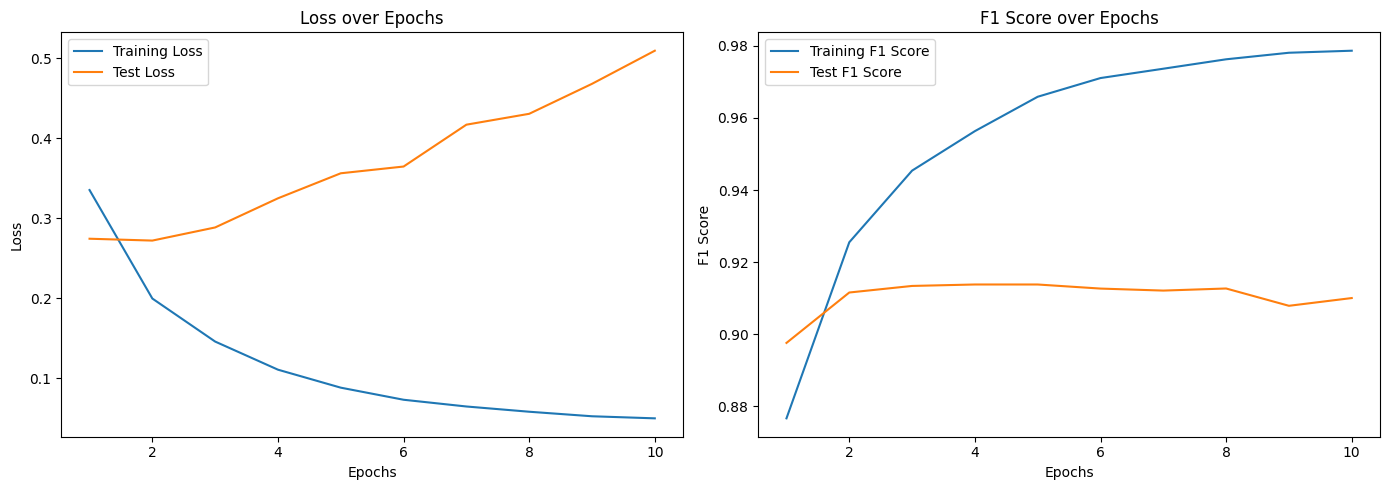

Final Test Accuracy: 0.9124

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.63      0.67      1415
     neutral       0.94      0.96      0.95     15916
    positive       0.82      0.71      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



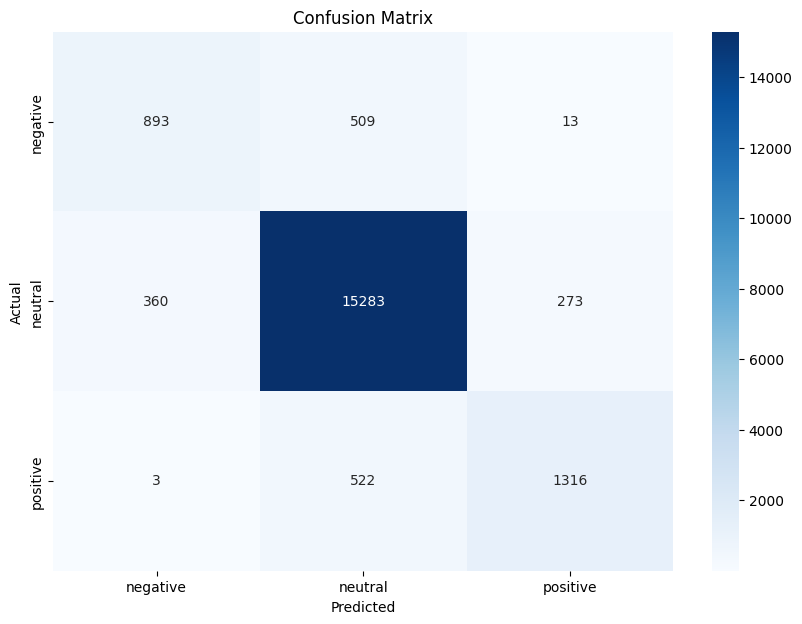

In [46]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize LSTM model
lstm_model = LSTMModel(input_size=X_train_dense.shape[1], hidden_size=128, output_size=len(set(y_train)))

# Training and evaluation process
train_model(lstm_model, train_loader, test_loader, num_epochs=10)


##GRU

Epoch 1/10, Train Loss: 0.3380, Train F1: 0.8756
Epoch 1/10, Test Loss: 0.2804, Test F1: 0.8981
____________________________
Epoch 2/10, Train Loss: 0.2038, Train F1: 0.9237
Epoch 2/10, Test Loss: 0.2909, Test F1: 0.9061
____________________________
Epoch 3/10, Train Loss: 0.1501, Train F1: 0.9429
Epoch 3/10, Test Loss: 0.2975, Test F1: 0.9092
____________________________
Epoch 4/10, Train Loss: 0.1160, Train F1: 0.9558
Epoch 4/10, Test Loss: 0.3240, Test F1: 0.9128
____________________________
Epoch 5/10, Train Loss: 0.0910, Train F1: 0.9648
Epoch 5/10, Test Loss: 0.3725, Test F1: 0.9120
____________________________
Epoch 6/10, Train Loss: 0.0759, Train F1: 0.9700
Epoch 6/10, Test Loss: 0.3986, Test F1: 0.9119
____________________________
Epoch 7/10, Train Loss: 0.0658, Train F1: 0.9737
Epoch 7/10, Test Loss: 0.4222, Test F1: 0.9119
____________________________
Epoch 8/10, Train Loss: 0.0600, Train F1: 0.9756
Epoch 8/10, Test Loss: 0.4568, Test F1: 0.9112
____________________________


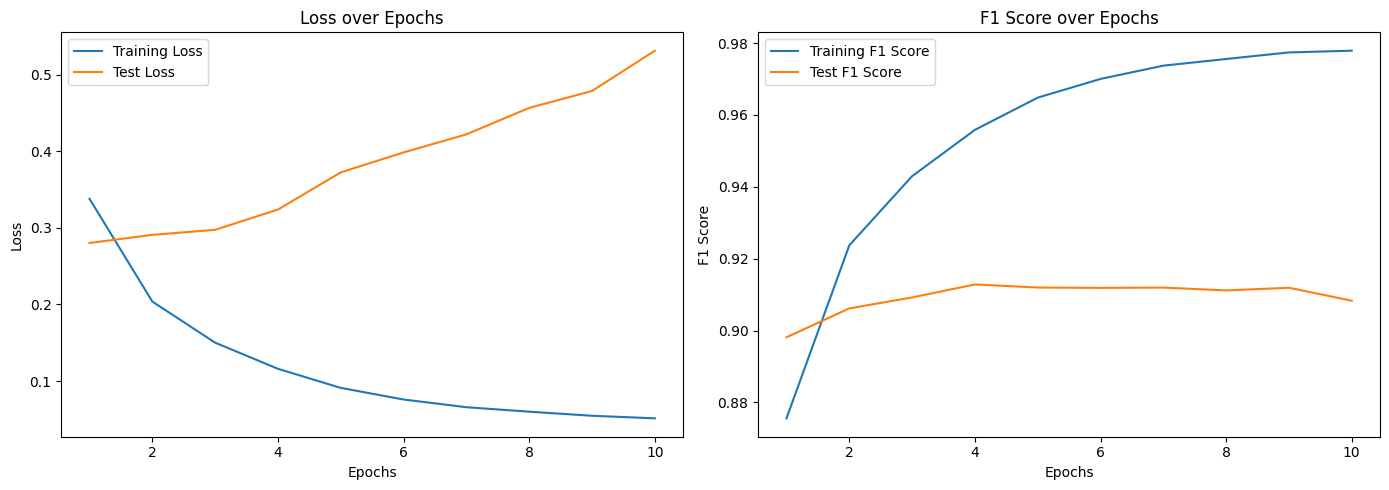

Final Test Accuracy: 0.9111

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.62      0.66      1415
     neutral       0.93      0.96      0.95     15916
    positive       0.83      0.70      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.76      0.79     19172
weighted avg       0.91      0.91      0.91     19172



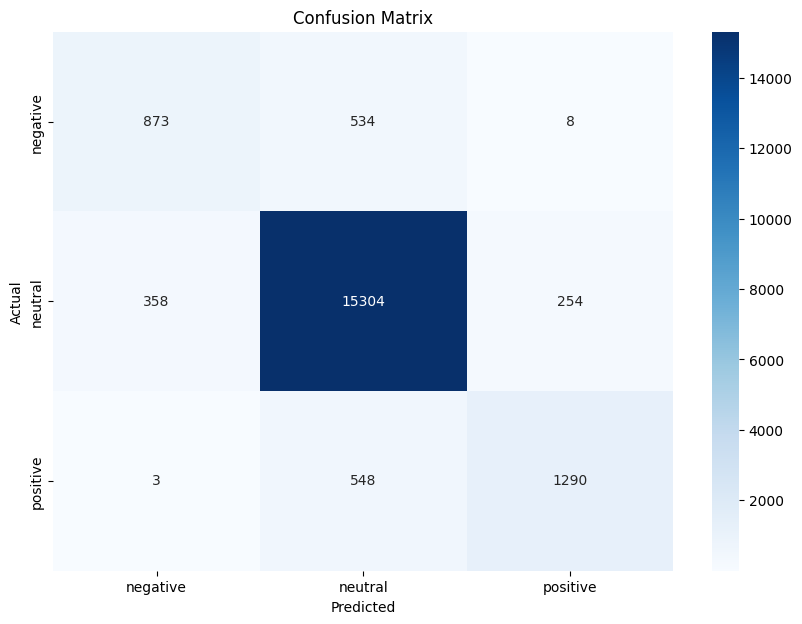

In [47]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize GRU model
gru_model = GRUModel(input_size=X_train_dense.shape[1], hidden_size=128, output_size=len(set(y_train)))

# Training and evaluation process
train_model(gru_model, train_loader, test_loader, num_epochs=10)
